## Parse the .xml document from OpenSubtitle

1. How to define a dialog? Using time difference?
2. Consequent lines may be spoken by same person -- not a dialog at all.
3. 还有重复的0-790764文件夹里三个都是一部剧
同一个文件夹里的出门xml应该是同一部剧的字幕
4. 甚至有歌词666文件夹
5. 旁白怎么区分1858-4037526
6. 

一个s tag里多个time tag：同一个人讲的一句话
一个time tag跨越多个s tag：同一句话

s代表一句话 time表示同一时间屏幕上显示的句子
s中多个time：句子过长分多次显示
time中多s：多人不同的对话同时显示（短对话）

还有可能一整段s里没有time tag

` <s id="11">
    <time id="T11S" value="00:01:51,487" />
    <w id="11.1">I</w>
    <w id="11.2">don</w>
    <w id="11.3">'t</w>
    <w id="11.4">know</w>
    <w id="11.5">,</w>
    <w id="11.6">baby</w>
    <w id="11.7">.</w>
  </s>
  <s id="12">
    <w id="12.1">I</w>
    <w id="12.2">never</w>
    <w id="12.3">looked</w>
    <w id="12.4">.</w>
    <time id="T11E" value="00:01:53,682" />
  </s>`
` 
<s id="20">
    <time id="T17S" value="00:02:08,687" />
    <w id="20.1">Don</w>
    <w id="20.2">'t</w>
    <w id="20.3">you</w>
    <w id="20.4">want</w>
    <w id="20.5">to</w>
    <w id="20.6">try</w>
    <w id="20.7">the</w>
    <w id="20.8">wheelbarrow</w>
    <w id="20.9">...</w>
    <time id="T17E" value="00:02:11,042" />
    <time id="T18S" value="00:02:11,087" />
    <w id="20.10">or</w>
    <w id="20.11">the</w>
    <w id="20.12">praying</w>
    <w id="20.13">donkey</w>
    <w id="20.14">...</w>
    <time id="T18E" value="00:02:12,486" />
    <time id="T19S" value="00:02:12,527" />
    <w id="20.15">or</w>
    <w id="20.16">the</w>
    <w id="20.17">Chinese</w>
    <w id="20.18">shag</w>
    <w id="20.19">swing</w>
    <w id="20.20">?</w>
    <time id="T19E" value="00:02:14,358" />
  </s>
`

`
  <s id="17">
    <time id="T15S" value="00:02:04,367" />
    <w id="17.1">-</w>
    <w id="17.2">Again</w>
    <w id="17.3">?</w>
  </s>
  <s id="18">
    <w id="18.1">-</w>
    <w id="18.2">Sure</w>
    <w id="18.3">,</w>
    <w id="18.4">baby</w>
    <w id="18.5">.</w>
    <time id="T15E" value="00:02:06,323" />
  </s>
`

`
 </s>
  <s id="105">
    <time id="T103S" value="00:08:51,687" />
    <w id="105.1">-</w>
    <w id="105.2">Shut</w>
    <w id="105.3">up</w>
    <w id="105.4">,</w>
    <w id="105.5">you-</w>
    <w id="105.6">-</w>
  </s>
  <s id="106">
    <w id="106.1">-</w>
    <w id="106.2">OK</w>
    <w id="106.3">,</w>
    <w id="106.4">come</w>
    <w id="106.5">on</w>
    <w id="106.6">.</w>
    <time id="T103E" value="00:08:53,723" />
  </s>
`
直接去除- -之间的内容也会有问题

Static:

1. General time duration of documents;
2. Histogram for the time difference between two sentences, and tried to find the proper time stamp to decide dialog

Delete brackets and contents in brackets.

In [1]:
import xml.etree.ElementTree as ET
from datetime import datetime,timedelta
import operator
import matplotlib.pyplot as plt
import numpy as np
import os,re,time

In [2]:
def time2sec(string):
    # format = '%H:%M:%S'
    # d = datetime.strptime(string, format) 
    # string = string.replace(',','.')
    # d = list(map(float,string.split(':')))
    string = string.replace(' ','')
    d = list(map(float,re.split('\.|,|;|:',string)))
    t = timedelta(hours = d[0],minutes = d[1],seconds = d[2])
    return(t.total_seconds())

In [3]:
def multiple_replace(dict_, text):
    # Create a regular expression  from the dictionary keys
    regex = re.compile("(%s)" % "|".join(map(re.escape, dict_.keys())))
    # For each match, look-up corresponding value in dictionary
    return regex.sub(lambda mo: dict_[mo.string[mo.start():mo.end()]], text) 

dict_sub = {'\'s':'is','\'m':'am','\'t':'not','\'ve':'have',
            'don not':'do not','didn not':'did not','doesn not':'does not',
            'haven not':'have not','hasn not':'has not','isn not':'is not','aren not':'are not',
            'let is':'let us','shouldn not':'should not',
            'Don not':'Do not','Didn not':'Did not','Doesn not':'Does not',
            'Haven not':'Have not','Hasn not':'Has not','Isn not':'Is not','Aren not':'Are not',
            'Let is':'Let us','Shouldn not':'Should not'}

In [4]:
def OpenSubtitleSentence(file_path,FOLDER_PATH,dict_=dict_sub):
    # import data
    tree = ET.parse(file_path)
    root = tree.getroot()
    time_list = []
    s_list = []
    s_tmp = ''
    flag_s = 0
    flag_e = 0
    flag_m = 0
    
    # get duration of input document
    for sub in root.iter('subtitle'):
        for duration in sub.iter('duration'):
            duration_time = time2sec(duration.text.split(',')[0])
    
    # if the duration is too short or too long we ignore this document
    if (duration_time < 3600*0.5) | (duration_time > 3600*3):
        return
    
    for child in root:
        if child.tag != 's':
            continue
                    
        # get the list of start and end time of each sentence
        time_tmp = []
        for time in child.iter(tag='time'):
            # time_tmp.append(time.attrib['value'])
            time_tmp.extend([time.attrib['id'],time.attrib['value']])
        
        if not time_tmp:
            flag_m = 1
        elif (time_tmp[0].endswith('S')) & (time_tmp[-2].endswith('E')):
            time_list.extend([time_tmp[1],time_tmp[-1]])
        elif (time_tmp[0].endswith('E')) & (time_tmp[-2].endswith('S')):
            flag_m = 1
        elif (time_tmp[0].endswith('S')) & (time_tmp[-2].endswith('S')):
            time_list.extend([time_tmp[1]])
            flag_s = 1
        elif (time_tmp[0].endswith('E')) & (time_tmp[-2].endswith('E')):
            time_list.extend([time_tmp[-1]])
            flag_e = 1
        
        s = [] # sentence in this loop
        if child.itertext(): #sentence in each s tag
            s.append(''.join(child.itertext()))
        s = ' '.join(s[0].split())
        a = s
        
        a = multiple_replace(dict_, a)
        a = multiple_replace(dict_, a)
        
        # remove brackets and contents in the brackets/special symbols
        a = re.sub(u"\\(.*?\\)|\\{.*?}|\\[.*?]|\\♪.*?♪|\\#.*?#", "", a)
        a = re.sub('[0-9]+', 'NUM', a) # replace specific number with NUM
        # a = a.replace('-','')
        a = a.lstrip().rstrip()# remove '-' and spaces before or after sentence
        
        if flag_s:
            s_tmp = a
            flag_s = 0
            continue
        
        if flag_m:
            try:
                s_tmp = s_tmp + a
            except:
                print(child.attrib)
            flag_m = 0
            continue
            
        if flag_e:
            a = s_tmp + a
            flag_e = 0
            s_tmp = ''
            
        if (not len(a)) | (any(re.findall(r' Season.*?Episode | Subtitle :',a, re.IGNORECASE))): 
            # skip null sentence and - Season x Episode x - lines
            del time_list[-2:]
            continue
           
        s_list.append(a)
#         new_path = os.path.basename(file_path).split('.')[0]
#         f = open(new_path+'.txt','a')
#         f.write(a)
#         f.write('\n')
                
    # convert to seconds
    time_second = []
    for time in time_list:
        # print(child.attrib,time)
        time_second.append(time2sec(time))

    time_diff = list(map(operator.sub,time_second[::2][1:],time_second[1::2][:-1]))
    
    # save dialogue
    folder = FOLDER_PATH
    new_path = folder + os.path.basename(file_path).split('.')[0] + '.txt'
    SaveSentence(new_path,s_list,time_diff)
    
    return

In [5]:
def SaveSentence(save_path,s_,time_):
    n = 1
    new_path = save_path
    while os.path.exists(new_path):
        new_path = save_path.split('.')[0]+'_'+str(n)+'.txt'
        n +=1
        
    time_th = np.percentile(time_,75)
    print(time_th)
    f = open(new_path,'a')
    for i in range(len(s_)-1):
        a = '<BOS>'+s_[i]+'<EOS>'
        f.write(a)
        f.write("\n")
        if time_[i]>=time_th:
            f.write(">>>>>")
            f.write("\n")
    a = '<BOS>'+s_[-1]+'<EOS>'
    f.write(a)
    print(new_path)
    return

In [7]:
g = os.walk("/Volumes/Files/en/OpenSubtitles/xml/en/")
cnt = 0
folder_path = "/Volumes/Files/en/OpenSubtitles/txt/"
tos = time.clock()

# looping over all .xml files in that folder
for path,dir_list,file_list in g:  
    for file_name in file_list:
        if cnt%10000 == 0:
            runtime = time.clock()-tos
            tos = runtime
            print('\n')
            print('============================')
            print('Processing :',cnt/446612,'running time is',runtime,'s')
            print('============================','\n')
        if file_name.endswith(".xml"): 
            tmp_path = os.path.join(path,file_name)
            time_diff_ = OpenSubtitleSentence(tmp_path,folder_path)
            cnt += 1

/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.




Processing : 0.0 running time is 0.0025239999999999707 s

2.0
/Volumes/Files/en/OpenSubtitles/txt/4275264.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4276039.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/4275262.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/4276036.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4275265.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4276038.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4275263.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4276037.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4348668.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/3377035.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4639810.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/4307921.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/6521138.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4307920.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4307919.txt
2.25
/Volumes/Files/en/OpenSubtitles/txt/4307918.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4307917.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4307916.txt
2.0

1.0
/Volumes/Files/en/OpenSubtitles/txt/5152960.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/5166622.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5219145.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/5728714.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/5785312.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6031634.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4749946.txt
1.75
/Volumes/Files/en/OpenSubtitles/txt/6083182.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6083184.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6083186.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5569843.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/5882568.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4620977.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/4620979.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4620980.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6118588.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/3273095.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/5878203.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5878190.txt
2.0
/Volume

2.0
/Volumes/Files/en/OpenSubtitles/txt/6049250.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6049252.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6049254.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6583095.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6838872.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6838921.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6838922.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6898481.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/7059331.txt
6.0
/Volumes/Files/en/OpenSubtitles/txt/6964426.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6898484.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6672500.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6672501.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/7039339.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/7039336.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/7039334.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6899294.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6906876.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6867320.txt
0.5
/Volumes

1.0
/Volumes/Files/en/OpenSubtitles/txt/3110998.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3877784.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6241679.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5635850.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5635851.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/5638486.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5819356.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6110896.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6309163.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/5993935.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6758679.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6859449.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/5993964.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6758680.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/5065003.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3170327.txt
8.0
/Volumes/Files/en/OpenSubtitles/txt/140697.txt
4.0
/Volumes/Files/en/OpenSubtitles/txt/217647.txt
8.0
/Volumes/Files/en/OpenSubtitles/txt/217648.txt
169.0
/Volumes/

1.0
/Volumes/Files/en/OpenSubtitles/txt/3248348.txt
41.0
/Volumes/Files/en/OpenSubtitles/txt/3548843.txt
41.0
/Volumes/Files/en/OpenSubtitles/txt/3577528.txt
43.5
/Volumes/Files/en/OpenSubtitles/txt/6223654.txt
100.5
/Volumes/Files/en/OpenSubtitles/txt/4734460.txt
31.0
/Volumes/Files/en/OpenSubtitles/txt/3665037.txt
130.0
/Volumes/Files/en/OpenSubtitles/txt/4734419.txt
188.0
/Volumes/Files/en/OpenSubtitles/txt/5773673.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/215535.txt
17.5
/Volumes/Files/en/OpenSubtitles/txt/4114984.txt
66.5
/Volumes/Files/en/OpenSubtitles/txt/4734408.txt
31.5
/Volumes/Files/en/OpenSubtitles/txt/4183310.txt
40.0
/Volumes/Files/en/OpenSubtitles/txt/4734468.txt
57.0
/Volumes/Files/en/OpenSubtitles/txt/3137769.txt
20.0
/Volumes/Files/en/OpenSubtitles/txt/5177485.txt
29.0
/Volumes/Files/en/OpenSubtitles/txt/3627552.txt
29.0
/Volumes/Files/en/OpenSubtitles/txt/3698283.txt
29.0
/Volumes/Files/en/OpenSubtitles/txt/6294327.txt
29.0
/Volumes/Files/en/OpenSubtitles/txt/63404

38.0
/Volumes/Files/en/OpenSubtitles/txt/3699805.txt
79.0
/Volumes/Files/en/OpenSubtitles/txt/3659748.txt
25.75
/Volumes/Files/en/OpenSubtitles/txt/3656635.txt
25.0
/Volumes/Files/en/OpenSubtitles/txt/6292966.txt
30.0
/Volumes/Files/en/OpenSubtitles/txt/3378603.txt
27.5
/Volumes/Files/en/OpenSubtitles/txt/3530669.txt
27.5
/Volumes/Files/en/OpenSubtitles/txt/3566906.txt
46.0
/Volumes/Files/en/OpenSubtitles/txt/3330432.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/3986899.txt
35.0
/Volumes/Files/en/OpenSubtitles/txt/4219314.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/242313.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3080353.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/3080636.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/3080723.txt
21.75
/Volumes/Files/en/OpenSubtitles/txt/4996336.txt
38.5
/Volumes/Files/en/OpenSubtitles/txt/3341759.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3873830.txt
40.5
/Volumes/Files/en/OpenSubtitles/txt/6093043.txt
5.0
/Volumes/Files/en/OpenSubtitles/txt/17954.txt
5

29.0
/Volumes/Files/en/OpenSubtitles/txt/6669740.txt
31.0
/Volumes/Files/en/OpenSubtitles/txt/4668302.txt
36.0
/Volumes/Files/en/OpenSubtitles/txt/5626899.txt
43.75
/Volumes/Files/en/OpenSubtitles/txt/4735108.txt
35.25
/Volumes/Files/en/OpenSubtitles/txt/4681847.txt
32.5
/Volumes/Files/en/OpenSubtitles/txt/99021.txt
50.0
/Volumes/Files/en/OpenSubtitles/txt/3396669.txt
50.5
/Volumes/Files/en/OpenSubtitles/txt/3350724.txt
51.5
/Volumes/Files/en/OpenSubtitles/txt/5514823.txt
52.75
/Volumes/Files/en/OpenSubtitles/txt/3372179.txt
69.5
/Volumes/Files/en/OpenSubtitles/txt/4167857.txt
28.75
/Volumes/Files/en/OpenSubtitles/txt/3543979.txt
17.25
/Volumes/Files/en/OpenSubtitles/txt/3806865.txt
17.25
/Volumes/Files/en/OpenSubtitles/txt/3825039.txt
20.25
/Volumes/Files/en/OpenSubtitles/txt/4254576.txt
21.0
/Volumes/Files/en/OpenSubtitles/txt/3660006.txt
49.25
/Volumes/Files/en/OpenSubtitles/txt/3552179.txt
41.0
/Volumes/Files/en/OpenSubtitles/txt/4734276.txt
67.0
/Volumes/Files/en/OpenSubtitles/txt

30.0
/Volumes/Files/en/OpenSubtitles/txt/6944534.txt
21.0
/Volumes/Files/en/OpenSubtitles/txt/4996620.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/215847.txt
29.0
/Volumes/Files/en/OpenSubtitles/txt/6695465.txt
31.5
/Volumes/Files/en/OpenSubtitles/txt/6616991.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/3330064.txt
46.0
/Volumes/Files/en/OpenSubtitles/txt/3330078.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/172970.txt
61.5
/Volumes/Files/en/OpenSubtitles/txt/4015402.txt
85.25
/Volumes/Files/en/OpenSubtitles/txt/3100992.txt
48.75
/Volumes/Files/en/OpenSubtitles/txt/3134215.txt
53.0
/Volumes/Files/en/OpenSubtitles/txt/3204809.txt
48.75
/Volumes/Files/en/OpenSubtitles/txt/4265304.txt
42.0
/Volumes/Files/en/OpenSubtitles/txt/4448062.txt
251.0
/Volumes/Files/en/OpenSubtitles/txt/3181535.txt
7.0
/Volumes/Files/en/OpenSubtitles/txt/5128788.txt
48.0
/Volumes/Files/en/OpenSubtitles/txt/3609669.txt
40.0
/Volumes/Files/en/OpenSubtitles/txt/3693610.txt
30.0
/Volumes/Files/en/OpenSubtitles/txt/4642294

/Volumes/Files/en/OpenSubtitles/txt/4413678.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3746059.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4766796.txt
31.0
/Volumes/Files/en/OpenSubtitles/txt/3128644.txt
31.0
/Volumes/Files/en/OpenSubtitles/txt/5500778.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3265334.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3671691.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5242481.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3649670.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/105788.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6935753.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/175277.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3428460.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3735729.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5583644.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/5789244.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/86522.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/86523.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4145082.txt
45.0
/Volumes/Files/

2.0
/Volumes/Files/en/OpenSubtitles/txt/3685019.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4193621.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4748557.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6654419.txt
7.0
/Volumes/Files/en/OpenSubtitles/txt/4443400.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/6406611.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6606107.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/6646110.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/131077.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/213378.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3150872.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3178482.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/3333714.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3552446.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3841711.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4039617.txt
0.0
/Volumes/Files/en/OpenSubtitles/txt/4039626.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4205479.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4546678.txt
2.0
/Volumes/F

1.0
/Volumes/Files/en/OpenSubtitles/txt/175371.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/3978106.txt
22.0
/Volumes/Files/en/OpenSubtitles/txt/5159706.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3332245.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3387563.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3572080.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4445443.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/4445920.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/6421562.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/5019777.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/3331229.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3331236.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/3359775.txt
3.0
/Volumes/Files/en/OpenSubtitles/txt/6681261.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3182548.txt
1.0
/Volumes/Files/en/OpenSubtitles/txt/3333491.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/6100335.txt
2.0
/Volumes/Files/en/OpenSubtitles/txt/3333326.txt
7.0
/Volumes/Files/en/OpenSubtitles/txt/3674640.txt
3.0
/Volumes

IndexError: cannot do a non-empty take from an empty axes.

In [8]:
tmp_path

'/Volumes/Files/en/OpenSubtitles/xml/en/1932/22877/178645.xml'

In [13]:
file_count=0
for dirpath, dirnames, filenames in os.walk('/Volumes/Files/en/OpenSubtitles/xml/en/'):
    for file in filenames:
        file_count=file_count+1
print(file_count)
# file_count = 446612

446612


In [6]:
# the root data folder 
#g = os.walk("/Volumes/Files/en/OpenSubtitles/xml/en/")
g = os.walk('./')

total_time = []
total_dura = []
tos = time.clock()
# looping over all .xml files in that folder
for path,dir_list,file_list in g:  
    for file_name in file_list:
        if len(total_dura)%10000 == 0:
            runtime = time.clock()-tos
            tos = runtime
            print('\n')
            print('============================')
            print('Processing :',len(total_dura)/446612,'running time is',runtime,'s')
            print('============================','\n')
        if file_name.endswith(".xml"): 
            tmp_path = os.path.join(path,file_name)
            time_,duration_,s_ = OpenSubtitleSentence(tmp_path)
            print(len(time_),len(s_))
            # OpenSubtitleSentence(tmp_path)
            file_size = os.path.getsize(tmp_path)
            total_time.extend(time_)
            total_dura.append(duration_)
            if time_:
                print('File {file}, duration {dura}s,percentage time difference {time_diff}s, and file size {fsize}KB'.
                      format(file=tmp_path,dura=duration_,\
                      time_diff=np.percentile(time_,75),fsize=int(file_size/1024)))

/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/anaconda3/envs/semester/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':




Processing : 0.0 running time is 0.0015230000000001631 s

14 15
File ./BlackPanther.xml, duration 92.0s,percentage time difference 1.75s, and file size 5KB
298 299
File ./3602669.xml, duration 2.0s,percentage time difference 2.0s, and file size 116KB
1274 1275
File ./AustinPower_1999.xml, duration 5458.0s,percentage time difference 1.0s, and file size 413KB


In [5]:
print(tmp_path)

/Volumes/Files/en/OpenSubtitles/xml/en/1949/143235/4191883.xml


(array([5.363e+03, 4.582e+03, 1.210e+02, 1.100e+01, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([    0. ,  5423.3, 10846.6, 16269.9, 21693.2, 27116.5, 32539.8,
        37963.1, 43386.4, 48809.7, 54233. ]),
 <a list of 10 Patch objects>)

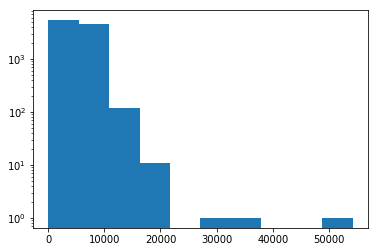

In [5]:
plt.hist(total_dura[1:],log=True)

(array([ 41.,  73., 182.,  83.,  62.,  37.,  86., 225., 107.,  92.]),
 array([   0. ,  179.7,  359.4,  539.1,  718.8,  898.5, 1078.2, 1257.9,
        1437.6, 1617.3, 1797. ]),
 <a list of 10 Patch objects>)

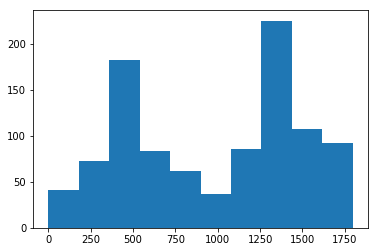

In [9]:
test = np.array(total_dura)
test = test[test<1800]
plt.hist(test)

In [10]:
len(test)

988

In [8]:
len(total_dura)

8242

In [6]:
tree = ET.parse(tmp_path)
root = tree.getroot()